In [1]:
import monai
import lightning as L
from lightning import Callback, LightningDataModule, LightningModule, Trainer
import torch
import yaml
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import torchio as tio
from PIL import Image
from pathlib import Path
from typing import Any, Dict, List, Tuple
import pandas as pd

from src.models.build_sam3D import sam_model_registry3D
from src.dataset.ct_dataset import CTDataModule

data_path = Path("/media/7tb_encrypted/od_chall/dataset/challenge_data")
this_path = Path().resolve()
print(this_path)

/home/alejandrocu/OutlierDetectionChallenge2024/deep_learning


In [2]:
batch_size = 3
num_workers = 4
voxel_size = (1, 1, 1) #(0.5, 0.5, 0.5) #(1.171875, 1.171875, 2.5) #(1.5, 1.5, 1.5)
crop_size = (128, 128, 128) #(336, 224, 64) #(128, 128, 128)
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
train_ids = pd.read_csv(this_path / "custom_train_list_100.txt", header=None)[0].tolist()
val_ids = pd.read_csv(this_path / "custom_validation_list_100.txt", header=None)[0].tolist()

transforms = tio.Compose([
                            tio.transforms.ToCanonical(),
                            tio.transforms.Resample(voxel_size), # , image_interpolation='cosine'
                            tio.transforms.CropOrPad(crop_size, padding_mode=-1000), # padding_mode=0), #
                            tio.transforms.Clamp(-1000, 1000),
                            tio.transforms.RescaleIntensity(out_min_max=(0.0, 1.0), in_min_max=(-1000, 1000))
                            ])  

datamodule = CTDataModule(data_path=data_path/'train', 
                            batch_size=batch_size, 
                            num_workers=num_workers, 
                            voxel_size=voxel_size, 
                            crop_size=crop_size,
                            train_ids=train_ids,
                            val_ids=val_ids,
                            transforms=transforms)
test_loader = datamodule.val_dataloader()
train_loader = datamodule.train_dataloader()

Loaded 400 samples
Label distribution: label
1    300
0    100
Name: count, dtype: int64
Loaded 400 samples
Label distribution: label
1    300
0    100
Name: count, dtype: int64


In [3]:
sample = next(iter(train_loader))

In [4]:
sample['image'].shape

torch.Size([3, 1, 128, 128, 128])

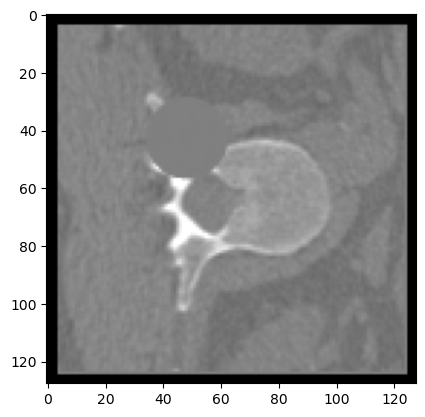

In [5]:
plt.imshow(sample['image'][0, 0, :, :, 64], cmap='gray')

In [6]:
ckpt_path = data_path.parent / 'sam_med3d_turbo.pth'
# with open(ckpt_path, "rb") as f:
#     state_dict = torch.load(f)
# state_dict['args']
# Namespace(task_name='ft_general', click_type='random', multi_click=False, model_type='vit_b_ori', checkpoint='ckpt/sam_med3d.pth', device=device(type='cuda', index=0), work_dir='work_dir',
#  num_workers=12, gpu_ids=[0, 1], multi_gpu=True, resume=False, allow_partial_weight=False, lr_scheduler='multisteplr', step_size=[120, 180], gamma=0.1, num_epochs=200, img_size=128, batch_size=12, accumulation_steps=20, lr=0.0008, weight_decay=0.1, port=12361, nodes=1, ngpus_per_node=2, world_size=2, rank=0)

sam_model = sam_model_registry3D['vit_b_ori'](checkpoint=None).to(device) #vit_b_ori
with open(ckpt_path, "rb") as f:
        state_dict = torch.load(f, map_location=device)
        sam_model.load_state_dict(state_dict['model_state_dict'])
print(sam_model.image_encoder.img_size)

/tmp/ipykernel_3372679/746488908.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=device)


128


In [8]:
sam_model.eval()
sam_model = sam_model.to(device)
avg_pool = torch.nn.AdaptiveAvgPool1d((1))

latents = []
rnd_latents = []
for batch in train_loader:
    batch = batch['image'].to(device)
    # rnd_input = torch.randn(batch_size, 1, 128, 128, 128).uniform_(0, 1).to(device)
    with torch.no_grad():
        latent = sam_model.image_encoder(batch)
        latent = latent.reshape(batch_size, latent.shape[1], -1)
        # rnd_latent = sam_model.image_encoder(rnd_input)
        # rnd_latent = rnd_latent.reshape(batch_size, rnd_latent.shape[1], -1)

        latents.append(avg_pool(latent).squeeze())
        # rnd_latents.append(avg_pool(rnd_latent).squeeze())

print(f'rnd shape: {len(rnd_latents)}, sample shape: {len(latents)}')

rnd shape: 0, sample shape: 133


In [11]:
latent.shape

torch.Size([3, 384, 512])

In [12]:
latents[0].shape

torch.Size([3, 384])

In [9]:
def RankMe(Z, epsilon=1e-10):
  """
  Computes the RankMe of a matrix Z.

  Args:
    Z: A numpy array of shape (N, K).
    epsilon: A small value to avoid division by zero.

  Returns:
    A numpy array of shape (N,).
  """
  sigma = np.linalg.svd(Z, full_matrices=False)[1]
  Pk = sigma / (np.linalg.norm(sigma, ord=1)) + epsilon
  return np.exp(-1 * np.sum(Pk * np.log(Pk), axis=0))

def singular_values_plot(latents: List[torch.Tensor], return_plots=True):
    
    latents = torch.cat(latents, dim=0)
    z = torch.nn.functional.normalize(latents, dim=1)

    # calculate covariance
    z = z.cpu().detach().numpy()
    z = np.transpose(z)
    c = np.cov(z)
    _, d, _ = np.linalg.svd(c)

    f_s = plt.figure()
    plt.plot(np.log(d))
    plt.xlabel('Singular Value Rank Index')
    plt.ylabel('Log Singular Value')

    f_cov = plt.figure()
    sns.heatmap(c)
    plt.title('Covariance Matrix')

    if return_plots:
        return f_s , f_cov
    else:
        return d, c

9.177454756422918


(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 2 Axes>)

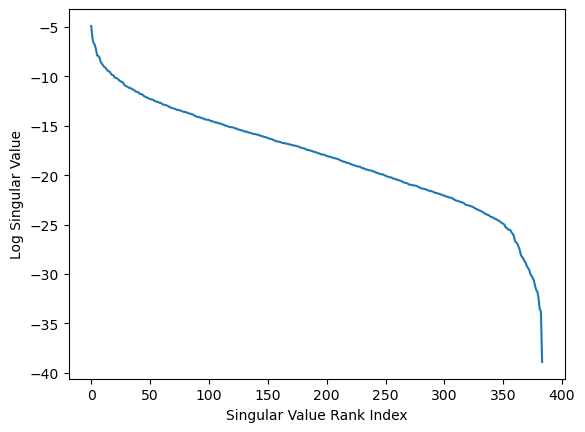

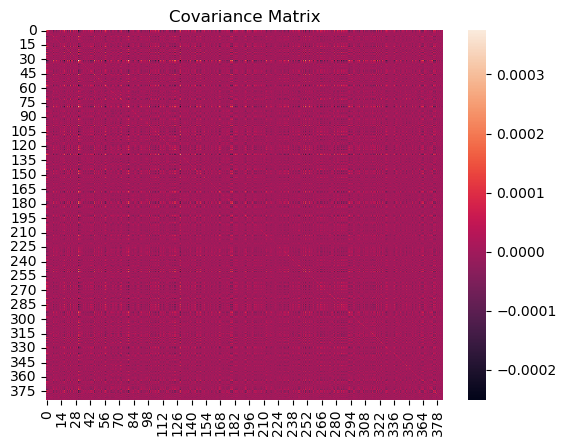

In [10]:
latents = [l.cpu() for l in latents]
print(RankMe(torch.cat(latents, dim=0).numpy()))
singular_values_plot(latents)